<a href="https://colab.research.google.com/github/coughlinjennie/data71200/blob/main/projects/DATA71200_Project2b_Coughlin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Supervised Learning
Because the field I want to use for labels is categorical — the property type — I'm using classifier models for this portion of the project. SVM, Gaussian naive Bayes, decision tree and KNN are the ones I'm considering.  


In [55]:
#Import the libraries and install scikit-learn
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import requests
import io
import matplotlib.pyplot as plt


!pip install -U scikit-learn==1.4

#Step 1: Import, split and clean the data
This is brought over from Project 1, with a fix to stratify when I split the data and a data pipeline for cleaning the data now that I know what needs to be done.

In [56]:
#Import the data, sourced from Kaggle and stored in my GitHub
url = "https://raw.githubusercontent.com/coughlinjennie/data71200/main/projects/nyhousing.csv" # Make sure the url is the raw version of the file on GitHub
download = requests.get(url).content
#Load the data

housing_master = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [57]:
housing_master["TYPE"].value_counts()

TYPE
Co-op for sale                1450
House for sale                1012
Condo for sale                 891
Multi-family home for sale     727
Townhouse for sale             299
Pending                        243
Contingent                      88
Land for sale                   49
For sale                        20
Foreclosure                     14
Condop for sale                  5
Coming Soon                      2
Mobile house for sale            1
Name: count, dtype: int64

I need to stratify the data when I split it, and the two values in this field that will interfere with that are ones I was going to drop anyway because they're not relevant for this model. (The TYPE field is showing the status of the property, but I'm using only the labels that indicate the property type and exclude the others, plus a couple that aren't super-relevant in New York.) We're not supposed to clean data until after we split it, but I can't figure out how to stratify the data for the split without doing this one step, so I'm going to do it anyway.

In [58]:
# Delete all rows where column 'TYPE' has certain values
indexType = housing_master[ (housing_master['TYPE'] == "For sale") | (housing_master['TYPE'] == "Contingent") | (housing_master['TYPE'] == "Land for sale") | (housing_master['TYPE'] == "Foreclosure") | (housing_master['TYPE'] == "Pending") | (housing_master['TYPE'] == "Coming Soon") | (housing_master['TYPE'] == "Mobile house for sale") ].index
housing_master.drop(indexType , inplace=True)

In [59]:
housing_master["TYPE"].value_counts()

TYPE
Co-op for sale                1450
House for sale                1012
Condo for sale                 891
Multi-family home for sale     727
Townhouse for sale             299
Condop for sale                  5
Name: count, dtype: int64

In [60]:
#Set the labels on TYPE

housing_label = housing_master["TYPE"]

#Set the data
housing = housing_master.drop("TYPE", axis=1)
print(housing)

                                            BROKERTITLE      PRICE  BEDS  \
0           Brokered by Douglas Elliman  -111 Fifth Ave     315000     2   
1                                   Brokered by Serhant  195000000     7   
2                                Brokered by Sowae Corp     260000     4   
3                                   Brokered by COMPASS      69000     3   
4     Brokered by Sotheby's International Realty - E...   55000000     7   
...                                                 ...        ...   ...   
4796                                Brokered by COMPASS     599000     1   
4797                    Brokered by Mjr Real Estate Llc     245000     1   
4798      Brokered by Douglas Elliman - 575 Madison Ave    1275000     1   
4799            Brokered by E Realty International Corp     598125     2   
4800                 Brokered by Nyc Realty Brokers Llc     349000     1   

           BATH  PROPERTYSQFT  \
0      2.000000   1400.000000   
1     10.000000  1754

In [61]:
#Divide the data into training and testing sets
from sklearn.model_selection import train_test_split

housing_train, housing_test, housing_label_train, housing_label_test = train_test_split(housing, housing_label, test_size=0.3, stratify=housing_label, random_state=42)


The ZIP code field was giving me fits trying to one hot encode it, so I'm trying this without that field to see if the model is useful enough without it.

In [62]:
# Create a list of redundant column names to drop from the training data only
to_drop = ["LONGITUDE", "LATITUDE", "ADDRESS", "ADMINISTRATIVE_AREA_LEVEL_2", "LOCALITY", "SUBLOCALITY", "FORMATTED_ADDRESS", "MAIN_ADDRESS", "STATE", "STREET_NAME","LONG_NAME","BROKERTITLE"]

# Drop those columns from the dataset
housing_subset = housing_train.drop(to_drop, axis = 1)
h_test_subset = housing_test.drop(to_drop, axis = 1)



In [63]:
#Drop all properties that sold for more than $1B from training data only

housing_clean = housing_subset[housing_subset['PRICE'] <= 100000000]
label_train_clean = housing_label_train[housing_subset['PRICE'] <= 100000000]


In [64]:
housing_clean.info()
label_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3067 entries, 2589 to 2311
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PRICE         3067 non-null   int64  
 1   BEDS          3067 non-null   int64  
 2   BATH          3067 non-null   float64
 3   PROPERTYSQFT  3067 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 119.8 KB
<class 'pandas.core.series.Series'>
Index: 3067 entries, 2589 to 2311
Series name: TYPE
Non-Null Count  Dtype 
--------------  ----- 
3067 non-null   object
dtypes: object(1)
memory usage: 47.9+ KB


In [65]:
housing_clean.describe()

,PRICE,BEDS,BATH,PROPERTYSQFT
count,3.067000e+03,3067.000000,3067.000000,3067.000000
mean,1.955427e+06,3.401043,2.392915,2202.658046
std,4.342835e+06,2.810770,2.058869,2420.874714
min,4.950000e+04,1.000000,0.000000,250.000000
25%,4.990000e+05,2.000000,1.000000,1166.500000
50%,8.450000e+05,3.000000,2.000000,2184.207862
75%,1.499000e+06,4.000000,3.000000,2184.207862
max,6.500000e+07,50.000000,50.000000,65535.000000


That no bathroom property is going to cause an issue transforming, so I'm going to remove it, too.

In [66]:
housing_clean.shape

(3067, 4)

#Step 2: Prepare the Data
Once the data is cleaned, I need to process it so I can run various supervised models on it.

In [67]:
#Import pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

log_pipeline = make_pipeline(SimpleImputer(missing_values= np.nan, strategy="median"),
                             FunctionTransformer(np.log,feature_names_out="one-to-one"),
                             StandardScaler())
num_pipeline = make_pipeline(SimpleImputer(strategy="median"))

preprocessing = ColumnTransformer([
    ("log", log_pipeline, ["BEDS","PROPERTYSQFT"]),
    ("std", num_pipeline, ["PRICE", "BATH"])
])

In [79]:
#Prepare the training data
housing_prepared = preprocessing.fit_transform(housing_clean)
housing_prepared.shape
housing_prepared.reshape(-1,1)

array([[1.35352879e-01],
       [1.57319317e-02],
       [7.49000000e+05],
       ...,
       [3.36055259e-01],
       [1.99500000e+06],
       [4.00000000e+00]])

In [80]:
#Prepare the testing data
h_test_prep = preprocessing.fit_transform(h_test_subset)
h_test_prep.reshape(-1,1)


array([[1.47348927e-01],
       [3.50010300e-01],
       [7.75000000e+05],
       ...,
       [1.41505775e+00],
       [1.59999900e+06],
       [2.37386086e+00]])

#Step 3: Examine the Target Attribute
The TYPE field is my target attribute

In [136]:
properties = label_train_clean.value_counts()

TYPE
Co-op for sale                1015
House for sale                 708
Condo for sale                 623
Multi-family home for sale     509
Townhouse for sale             209
Condop for sale                  3
Name: count, dtype: int64

That cond-op category is going to be a tough one because there are so few in it. Townhouses also seem like they could be problematic because there are so few.

#Step 4: Select Classifier Models

Since I'm trying to predict a categorical label — the type of property — I'm only assessing classifier models for this project. I'm going to try K-Nearest Neighbors and the Decision Tree classifiers

In [74]:
#import models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection



#Step 5: Run and Assess the Models
Three components here:

1.   Run with the defaults
2.   Run again and use cross-validation
3.   Adjust parameters for the model(s) using grid search




##Step 5a: Run with defaults

In [86]:
#Run K-Neighbors with defaults
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(housing_prepared, label_train_clean)
housing_predict = knn.predict(h_test_subset.values)
print("Test set score: {:.2f}".format(knn.score(h_test_subset.values, housing_label_test)))


Test set score: 0.33


In [87]:
from sklearn.metrics import precision_score
precision_score(housing_label_test, housing_predict, average=None)

from sklearn.metrics import recall_score
recall_score(housing_label_test, housing_predict, average=None)

from sklearn.metrics import f1_score

# Calculate metrics globally by counting the total true positives, false negatives and false positives.
print(f1_score(housing_label_test, housing_predict, average='micro'))
# Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
print(f1_score(housing_label_test, housing_predict, average='macro'))
# Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
print(f1_score(housing_label_test, housing_predict, average='weighted'))

# Class-wise, no averaging
print(f1_score(housing_label_test, housing_predict, average=None))

0.3305471124620061
0.08280982295830953
0.16423528717415495
[0.49685894 0.         0.         0.         0.         0.        ]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


This model is not very good at all.

In [102]:
#Run DecisionTree with defaults
tree = DecisionTreeClassifier(random_state=0)
tree.fit(housing_prepared, label_train_clean)
housing_predict = tree.predict(h_test_subset.values)
print("Test set score: {:.2f}".format(tree.score(h_test_subset.values, housing_label_test)))


Test set score: 0.23


In [121]:
from sklearn.metrics import classification_report



print("Accuracy on training set: {:.3f}".format(tree.score(h_test_subset.values, housing_label_test)))
print("Accuracy on test set: {:.3f}".format(tree.score(h_test_prep, housing_label_test)))
print(classification_report(housing_label_test, tree.predict(h_test_prep),
                            target_names=["class 1", "class 2","class 3", "class 4", "class 5", "class 6"]))

Accuracy on training set: 0.231
Accuracy on test set: 0.492
              precision    recall  f1-score   support

     class 1       0.73      0.67      0.70       435
     class 2       0.49      0.36      0.41       267
     class 3       0.00      0.00      0.00         2
     class 4       0.36      0.85      0.50       304
     class 5       0.00      0.00      0.00       218
     class 6       0.00      0.00      0.00        90

    accuracy                           0.49      1316
   macro avg       0.26      0.31      0.27      1316
weighted avg       0.42      0.49      0.43      1316



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


This default model is somehow even worse on the training data, but does considerably better on the test data. Interesting. The biggest class was the one with the best F1 score, but three classes have F1-scores of zero.

##Step 5b: Run again and use cross-validation

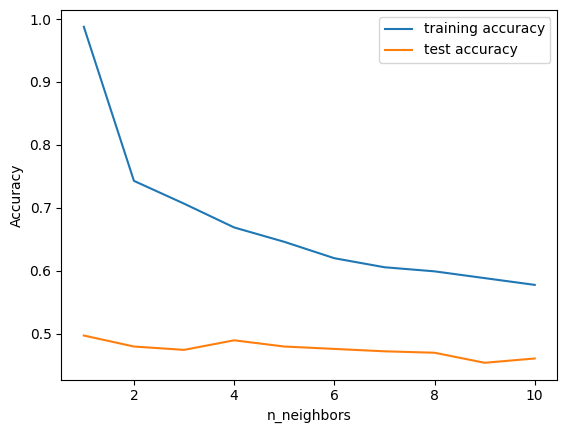

In [88]:
# test KNN with cross validation on test set
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(housing_prepared, label_train_clean)
    # record training set accuracy
    training_accuracy.append(knn.score(housing_prepared, label_train_clean))
    # record generalization accuracy
    test_accuracy.append(knn.score(h_test_prep, housing_label_test))

plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

It looks like n = 4 is the most accurate on the test set, although none of them are great.

Because the smallest group, cond-ops, only has three rows, the maximum number of folds I can do is three.

In [90]:
from sklearn.model_selection import cross_val_score

knn_cv = KNeighborsClassifier(n_neighbors=4)

#5-fold cross validation
cv_scores = cross_val_score(knn_cv, housing_prepared, label_train_clean, cv=3)

print("cv_scores:\n{}".format(cv_scores))
print("cv_scores mean:\n{}".format(np.mean(cv_scores)))

cv_scores:
[0.47507331 0.46086106 0.46477495]
cv_scores mean:
0.46690310720359324


The score on the test data is below 50 percent, but the cross-validation scores all are pretty similar.

In [118]:
# test Decision Tree with cross validation on test set
tree_cv = DecisionTreeClassifier(random_state=0)

#5-fold cross validation
cv_scores = cross_val_score(tree_cv, housing_prepared, label_train_clean, cv=3)

print("cv_scores:\n{}".format(cv_scores))
print("cv_scores mean:\n{}".format(np.mean(cv_scores)))

cv_scores:
[0.59237537 0.54598826 0.56262231]
cv_scores mean:
0.5669953113611973


These scores have more variation than KNN, but they're also noticeably better.  

In [112]:
print("Feature importances:")
print(tree.feature_importances_)

Feature importances:
[0.15496969 0.25703864 0.39749852 0.19049316]


This could be interesting to experiment with. None of the features has a weight of 0.4 or higher, but the two lowest ones are fairly close.

In [122]:
#Limiting the depth
tree = DecisionTreeClassifier(max_depth=3, random_state=0)
tree.fit(housing_prepared, label_train_clean)
housing_predict = tree.predict(h_test_subset.values)
print("Test set score: {:.2f}".format(tree.score(h_test_subset.values, housing_label_test)))
print("Accuracy on training set: {:.3f}".format(tree.score(h_test_subset.values, housing_label_test)))
print("Accuracy on test set: {:.3f}".format(tree.score(h_test_prep, housing_label_test)))
print(classification_report(housing_label_test, tree.predict(h_test_prep),
                            target_names=["class 1", "class 2","class 3", "class 4", "class 5", "class 6"]))

Test set score: 0.17
Accuracy on training set: 0.166
Accuracy on test set: 0.594
              precision    recall  f1-score   support

     class 1       0.80      0.72      0.76       435
     class 2       0.63      0.48      0.54       267
     class 3       0.00      0.00      0.00         2
     class 4       0.43      0.66      0.52       304
     class 5       0.55      0.64      0.59       218
     class 6       0.00      0.00      0.00        90

    accuracy                           0.59      1316
   macro avg       0.40      0.42      0.40      1316
weighted avg       0.58      0.59      0.58      1316



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


When I limited the depth to 2, I got the same results. But splitting the difference and limiting the depth to three made a difference. The training score declined considerably, but the test score increased. Also, one of the classes with a zero F1-score has improved to 0.59 and all the classes that had positive scores improved them.  

##Step 5c: Adjust parameters for the model(s) using grid search

In [93]:
from sklearn.model_selection import GridSearchCV

# parameter validation on training set

knn2 = KNeighborsClassifier()

#dictionary of all values of k
param_grid = {"n_neighbors": np.arange(1, 25)}

#grid search on all values of k in dictionary
knn_gscv = GridSearchCV(knn2, param_grid, cv=3)
knn_gscv.fit(housing_prepared, label_train_clean)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [94]:
#best performing k (on training set)
knn_gscv.best_params_

{'n_neighbors': 6}

In [95]:
#accuracy of best performing k
knn_gscv.best_score_

0.474725475830204

In [96]:
# full cross valiadation results from grid search
knn_gscv.cv_results_

{'mean_fit_time': array([0.0074935 , 0.00875028, 0.00679239, 0.00487145, 0.00436441,
        0.00404175, 0.00402602, 0.00527422, 0.00404763, 0.0040497 ,
        0.00436195, 0.00443705, 0.00392699, 0.0040226 , 0.00472736,
        0.00454156, 0.00425076, 0.00404485, 0.00406528, 0.00454577,
        0.00427628, 0.00391547, 0.00423702, 0.00389894]),
 'std_fit_time': array([9.13267671e-04, 2.79231045e-03, 1.99405023e-04, 1.16851061e-03,
        7.26193830e-04, 8.13475279e-05, 1.18732984e-04, 1.09913334e-03,
        2.76797570e-04, 3.80766953e-04, 3.46590444e-04, 3.49896917e-04,
        2.83287025e-05, 2.39697207e-04, 9.18988447e-04, 5.52733471e-04,
        3.92549415e-04, 2.52024064e-04, 2.02854938e-04, 2.26275380e-04,
        2.43007681e-05, 9.13597126e-05, 4.03920260e-04, 8.85990159e-05]),
 'mean_score_time': array([0.10072287, 0.11368195, 0.10238671, 0.0577395 , 0.05898778,
        0.05423299, 0.05697385, 0.06699888, 0.05657013, 0.05466016,
        0.0701251 , 0.05849147, 0.06133413, 0.05

The top three seem to be 6, 1 and 7, so I'm going to try out those, plus 2, which is more middle of the pack.

In [97]:
# accuracy of k = 6 on testing data (#1)
knn6 = KNeighborsClassifier(n_neighbors=6)
knn6.fit(housing_prepared, label_train_clean)
print("knn score: {}".format(knn6.score(h_test_prep, housing_label_test)))

knn score: 0.4756838905775076


In [98]:
# accuracy of k = 1 on testing data (#2)
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(housing_prepared, label_train_clean)
print("knn score: {}".format(knn1.score(h_test_prep, housing_label_test)))

knn score: 0.4969604863221885


In [99]:
# accuracy of k = 7 on testing data (#3)
knn7 = KNeighborsClassifier(n_neighbors=7)
knn7.fit(housing_prepared, label_train_clean)
print("knn score: {}".format(knn7.score(h_test_prep, housing_label_test)))

knn score: 0.47188449848024316


In [100]:
# accuracy of k = 2 on testing data (#9)
knn2 = KNeighborsClassifier(n_neighbors=2)
knn2.fit(housing_prepared, label_train_clean)
print("knn score: {}".format(knn2.score(h_test_prep, housing_label_test)))

knn score: 0.479483282674772


An n of 1 performed slightly better than the others, but the second-best performer was an n of 2, which was ranked ninth overall, so again, none of these seem to be all that great. KNN seems unlikely to be the best model choice for this problem.

In [123]:
#Testing out GridSearchCV on the decision tree model

param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [2, 3, 4],
              'criterion' :['gini', 'entropy']
             }
tree_clas = DecisionTreeClassifier(random_state=0)
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=3, verbose=True)
grid_search.fit(housing_prepared, label_train_clean)


Fitting 3 folds for each of 54 candidates, totalling 162 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
54 fits failed out of a total of 162.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4],
                         'max_features': ['auto', 'sqrt', 'log2']},
             verbose=True)

In [124]:
final_model = grid_search.best_estimator_
final_model

DecisionTreeClassifier(ccp_alpha=0.001, max_depth=4, max_features='sqrt',
                       random_state=0)

In [127]:
#Training the model
tree_clas = DecisionTreeClassifier(ccp_alpha=0.001,
                       max_depth=4, max_features='sqrt',
                       random_state=0)
tree_clas.fit(housing_prepared, label_train_clean)
print("Accuracy on training set: {:.3f}".format(tree_clas.score(h_test_subset.values, housing_label_test)))
print("Accuracy on test set: {:.3f}".format(tree_clas.score(h_test_prep, housing_label_test)))
print(classification_report(housing_label_test, tree_clas.predict(h_test_prep),
                            target_names=["class 1", "class 2","class 3", "class 4", "class 5", "class 6"]))

Accuracy on training set: 0.166
Accuracy on test set: 0.588
              precision    recall  f1-score   support

     class 1       0.85      0.63      0.73       435
     class 2       0.55      0.51      0.53       267
     class 3       0.00      0.00      0.00         2
     class 4       0.43      0.74      0.55       304
     class 5       0.74      0.50      0.60       218
     class 6       0.38      0.31      0.34        90

    accuracy                           0.59      1316
   macro avg       0.49      0.45      0.46      1316
weighted avg       0.64      0.59      0.60      1316



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


This did manage to improve the model, and now only the class with just two elements has an F1-score of 0. The other class F1-scores generally improved, and the overall F1 scores for the model improved. This model also is noticeably better than the KNN model, so it would be my choice of the two. It's still quite bad, though. If I were going to take this further, I would try a couple more models to see if any of them make big gains. If not, I would go back to the original data and find a way to use some of the location data without getting too granular, perhaps by aggregating the ZIP codes into a new field of neighborhood clusters that has maybe 15 to 30 classes vs. 179, and then one hot encoding the new field.